In [2]:
import matplotlib.pyplot as plt
import pdb
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 22
import numpy as np
from embeddings import load_embeddings
from lower_bound import lower_bound
from mechanism_base import OPTMech, ExponentialMechanism, EuclideanMechanism, ConstrOPTMech
from constr_mech import ExpConstrOPTMech
from tqdm import tqdm
import time
import pickle
import sys

In [3]:
from run_experiments import get_data_once, get_actual_epsilon

def get_data(mech, epsilons, save_path = None, stop_after = np.inf):
    res = []
    for e in epsilons:
        print(e)
        sys.stdout.flush()
        mech.epsilon = e 
        r = get_data_once(mech)
        res.append(r)
        if r['success'] and r['epsilon'] > stop_after:
            break

    res_dict = {}
    for i in range(0, len(res)):
        for k, v in res[i].items():
            if k in res_dict:
                res_dict[k].append(v)
            else:
                res_dict[k] = [v] 
    res_dict['name'] = mech.name
    res_dict['distance_matrix'] = mech.embeddings.distance_matrix
    if save_path is not None:
        pickle.dump(res_dict, open(save_path, 'wb'))
    return res_dict

In [4]:
exp_label = 'ExpMech'
opt_label = 'OPTMech'
constr_label = 'ConstrOPTMech'
spanner_label = 'SpannerMech'
weighted_label = 'WeightedExpMech'
euclid_label = 'EuclidMech'

In [5]:
#50 points in the random embedding
emb = load_embeddings('data/glove_sample_1000_0.5.txt', 50)
emb.save_ann()

In [6]:
euclid_mech = EuclideanMechanism(1.0, 10000, emb, True)
#euclid_data = get_data(euclid_mech, np.geomspace(1, 30, 10), 'data/50pts/glove/euclid_data.pkl')
euclid_data = pickle.load(open('data/50pts/glove/euclid_data.pkl', 'rb'))
euclid_data['name'] = euclid_label

In [7]:
exp_mech = ExponentialMechanism(1.0, emb)
exp_data = get_data(exp_mech, np.geomspace(0.02, 3.5, 10))
exp_data['name'] = exp_label

0.02
0.03550229640193614
0.06302065249054642
0.1118688942081397
0.19858013201671065
0.3525025353196436
0.6257324745675974
1.110746989020791
1.9717034415887114
3.5


In [8]:
opt_mech = OPTMech(1.0, emb, max_exp=10)
#opt_data = get_data(opt_mech, np.geomspace(0.05, 1.75, 10), 'data/50pts/glove/opt_data.pkl')
opt_data = pickle.load(open('data/50pts/glove/opt_data.pkl', 'rb'))
opt_data['name'] = opt_label

In [9]:
spanner, _ = emb.get_spanner(2.0)
spanner_opt_mech = OPTMech(1.0, emb, spanner, max_exp=10)
#span_data = get_data(spanner_opt_mech, np.geomspace(0.05, 1.4, 10), 'data/50pts/glove/spanner_data.pkl')
span_data = pickle.load(open('data/50pts/glove/spanner_data.pkl', 'rb'))
span_data['name'] = spanner_label

In [10]:
constr_opt_mech = ConstrOPTMech(1.0, emb, [0.001, 0.1, 1.0], max_exp=10)
constr_opt_mech.set_nns_heuristic(5)
#constr_data = get_data(constr_opt_mech, np.geomspace(0.05, 3.5, 10), 'data/50pts/glove/constr_data.pkl')
constr_data = pickle.load(open('data/50pts/glove/constr_data.pkl', 'rb'))
constr_data['name'] = constr_label

In [11]:
def correct_data(x, y):
    idxs = np.argsort(x)
    lowest = y[idxs[0]]
    include = [True]
    for i in range(1, len(x)):
        if y[idxs[i]] < lowest:
            lowest = y[idxs[i]]
            include.append(True)
        else:
            include.append(False)
    return idxs[include]

def plot_mech(mech, ax, utility_quantile, delta):
    if 'epsilon_correct' in mech:
        x = mech['epsilon_correct'].copy()
    else:
        x = np.array( [get_actual_epsilon(x, mech['distance_matrix'], delta).max() for x in mech['trans']] )
        mech['epsilon_correct'] = x.copy()
    #x = np.array(mech['epsilon'])
    y = np.array(mech['utility'])
    y = np.quantile(y, utility_quantile, axis=1)
    include = correct_data(x,y)
    x = x[include]
    y = y[include]
    ax.plot(x, y, label=mech['name'])
    #ax.fill_between(x, y0, y1, alpha=0.3, label = mech['name'], color=color)
    plt.legend()

In [12]:
result_list = [exp_data, constr_data, span_data, opt_data]

In [13]:
epsilons_lb = np.geomspace(0.05, 1.5, 10)
lb = lower_bound(emb.distance_matrix, epsilons_lb)

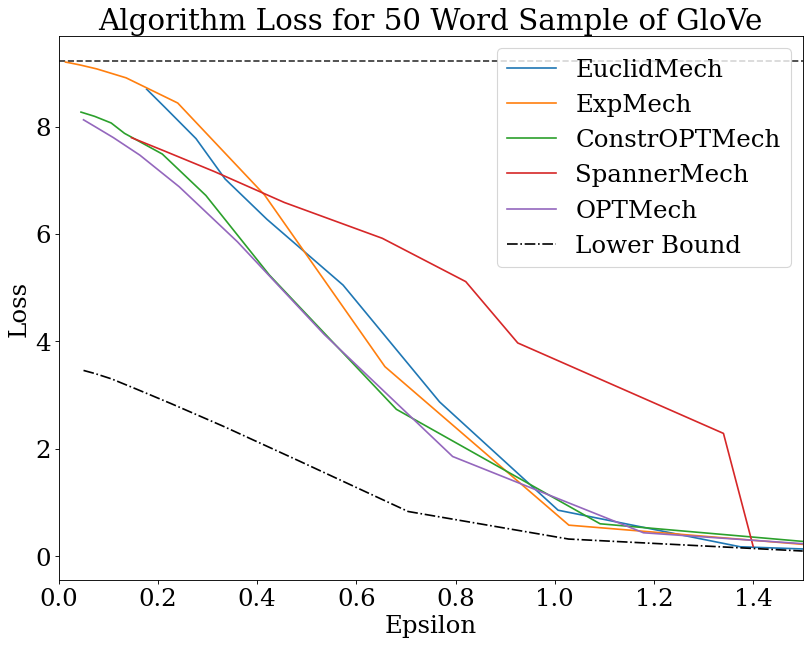

In [23]:
fig, ax = plt.subplots()
ax.set_xlabel('Epsilon')
ax.set_ylabel('Loss')
ax.set_title('Algorithm Loss for 50 Word Sample of GloVe')
ax.hlines(np.quantile(emb.distance_matrix.mean(axis=1), 0.95), 0, 2.0, color='k', linestyles='dashed', alpha=0.8)
plot_mech(euclid_data, ax, 0.95, 0.002)
for res in result_list:
    plot_mech(res, ax, 0.95, 0.001)
ax.set_xlim(0, 1.5)
ax.plot(epsilons_lb, lb, 'k-.', label='Lower Bound')
ax.legend()

In [14]:
np.quantile( np.array(opt_data['time']), 0.5)

8.565453290939331

In [15]:
emb = load_embeddings('data/glove_sample_1000_0.5.txt', 200)

In [16]:
exp_data = pickle.load(open('data/200pts/glove/exp_data.pkl', 'rb'))
exp_data['name'] = exp_label
constr_data = pickle.load(open('data/200pts/glove/constr_data_10.pkl', 'rb'))
constr_data['name'] = constr_label
span_data = pickle.load(open('data/200pts/glove/spanner_data.pkl', 'rb'))
span_data['name'] = spanner_label
euclid_data = pickle.load(open('data/200pts/glove/euclid_data.pkl', 'rb'))
euclid_data['name'] = euclid_label

In [17]:
lb = lower_bound(emb.distance_matrix, epsilons_lb)

/home/jimola/dptextgeometry/run_experiments.py:298: RuntimeWarning: divide by zero encountered in log
  eps = np.log(ratios[idxs[cutoff]]) / d
/home/jimola/dptextgeometry/run_experiments.py:298: RuntimeWarning: divide by zero encountered in log
  eps = np.log(ratios[idxs[cutoff]]) / d


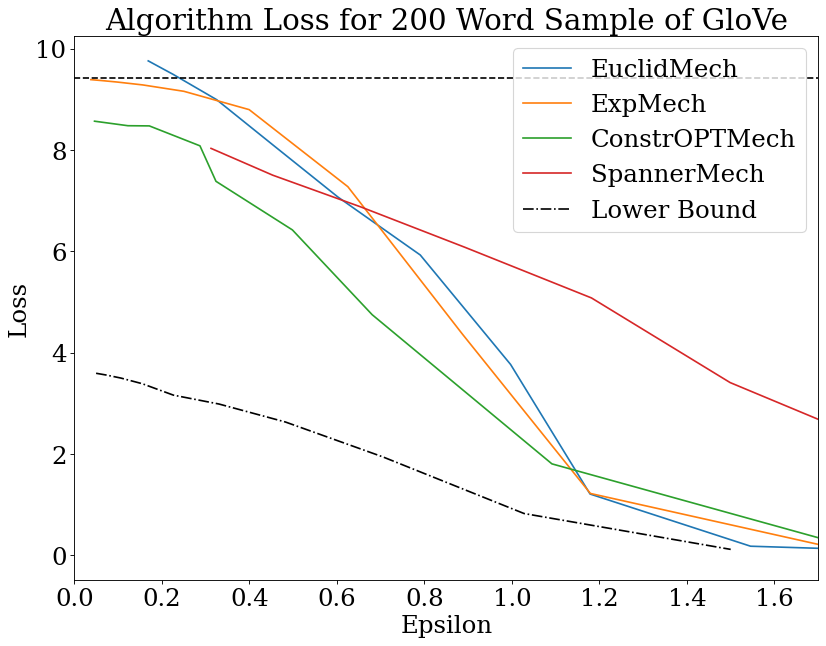

In [18]:
fig, ax = plt.subplots()
ax.set_xlabel('Epsilon')
ax.set_ylabel('Loss')
ax.set_title('Algorithm Loss for 200 Word Sample of GloVe')
plot_mech(euclid_data, ax, 0.95, 0.002)
for res in [exp_data, constr_data, span_data]:
    plot_mech(res, ax, 0.95, 0.001)
ax.plot(epsilons_lb, lb, 'k-.', label='Lower Bound')
ax.hlines(np.quantile(emb.distance_matrix.mean(axis=1), 0.95), 0, 3.0, color='k', linestyles='dashed')
ax.set_xlim(0, 1.7)
ax.legend()

In [16]:
exp_data = pickle.load(open('data/vary_pts/glove/exp_data.pkl', 'rb'))
constr_data = pickle.load(open('data/vary_pts/glove/constr_data_10.pkl', 'rb'))
constr_data_5 = pickle.load(open('data/vary_pts/glove/constr_data_5.pkl', 'rb'))
spanner_data = pickle.load(open('data/vary_pts/glove/spanner_data.pkl', 'rb'))

In [45]:
def multi_point_loss(data, epsilon, utility_quantile, delta=0.001):
    loss = []
    pts = []
    for k, dat in data.items():
        #emb = load_embeddings('data/fasttext_sample_1000_0.5.txt', k)
        if 'utility' in dat and 'trans' in dat:
            m = dat['distance_matrix']
            x = np.array([ get_actual_epsilon(t, m, delta).max() for t in dat['trans']])
            print(x)
            #x = np.array( dat['epsilon'] )
            y = np.array( list(map(lambda x: np.quantile(x, utility_quantile), dat['utility'])) )
            include = correct_data(x,y)
            x = x[include]
            y = y[include]
            if epsilon < x[0] or epsilon > x[-1]:
                print('possible interpolation inconsistency')
                print(epsilon)
                print(x)
            loss.append(np.interp(epsilon, x, y))
            pts.append(k)
    return (pts, loss)

In [46]:
epsilon = 1
exp_loss2 = multi_point_loss(exp_data, epsilon, 0.95)
constr_loss2 = multi_point_loss(constr_data, epsilon, 0.95)
constr_loss3 = multi_point_loss(constr_data_5, epsilon, 0.95)
spanner_loss2 = multi_point_loss(spanner_data, epsilon, 0.95)
#spanner_const_loss2 = multi_point_loss(spanner_const_data, 2.0, 0.95)
#weight_exp_loss2 = multi_point_loss(weight_exp_data, 2.0, 0.95)

[0.86756832 0.95329807 1.04113472 1.13147232]
[0.90660702 0.98833268 1.07018781 1.15437446]
[0.94128662 1.01856405 1.09809657 1.17846443]
[0.9705188  1.04237525 1.11086241 1.18609999]
[1.01659965 1.08375969 1.16486416 1.25192878]
possible interpolation inconsistency
1
[1.01659965 1.08375969 1.16486416 1.25192878]
[1.02844688 1.09391298 1.16951692 1.25679799]
possible interpolation inconsistency
1
[1.02844688 1.09391298 1.16951692 1.25679799]
[1.04138362 1.10936902 1.17829021 1.26389401]
possible interpolation inconsistency
1
[1.04138362 1.10936902 1.17829021 1.26389401]
[1.05094321 1.11914988 1.18490559 1.26958258]
possible interpolation inconsistency
1
[1.05094321 1.11914988 1.18490559 1.26958258]
[0.8 0.9 1.  1.1]
[0.8 0.9 1.  1.1]
[0.8 0.9 1.  1.1]
[0.8 0.9 1.  1.1]
[0.8 0.9 1.  1.1]
[0.8 0.9 1.  1.1]
[0.8 0.9 1.  1.1]
[0.8 0.9 1.  1.1]
[0.8 0.9 1.  1.1]
[0.8 0.9 1.  1.1]
[0.8 0.9 1.  1.1]
[0.86637359 0.9        1.         1.1       ]
[0.8        0.95514647 1.         1.1       ]
[0

/home/jimola/dptextgeometry/run_experiments.py:298: RuntimeWarning: divide by zero encountered in log
  eps = np.log(ratios[idxs[cutoff]]) / d


[1.18196442 1.41444004 1.57293896 1.83509545 1.69123262 1.91148544]
possible interpolation inconsistency
1
[1.18196442 1.41444004 1.57293896 1.69123262 1.91148544]
[1.15218642 1.57293896 1.83509545 1.84444232 2.02767814]
possible interpolation inconsistency
1
[1.15218642 1.57293896 1.83509545 1.84444232 2.02767814]


In [20]:
spanner_data[50]['utility']

[array([4.47870383, 4.47870383, 4.47870383, 4.47870383, 4.47870383,
        4.47870383, 4.47870383, 4.47870383, 4.47870383, 4.47870383,
        4.47870383, 4.47870383, 4.47870383, 4.47870383, 4.47870383,
        4.47870383, 4.47870383, 4.47870383, 4.47870383, 4.47870383,
        4.47870383, 4.47870383, 4.47870383, 4.47870383, 4.47870383,
        4.47870383, 4.47870383, 4.47870383, 4.47870383, 4.47870383,
        4.47870383, 4.47870383, 4.47870383, 4.47870383, 4.47870383,
        4.47870383, 4.47870383, 4.47870383, 3.84719964, 4.47870383,
        4.47870383, 4.47870383, 4.47870383, 4.47870383, 4.47870383,
        4.47870383, 4.47870383, 4.47870383, 4.47870383, 4.47870383]),
 array([3.6344179, 3.6344179, 3.6344179, 3.6344179, 3.6344179, 3.6344179,
        3.6344179, 3.6344179, 3.6344179, 3.6344179, 3.6344179, 3.6344179,
        3.6344179, 3.6344179, 3.6344179, 3.6344179, 3.6344179, 3.6344179,
        3.6344179, 3.6344179, 3.6344179, 3.6344179, 3.6344179, 3.6344179,
        3.6344179, 3.6

In [33]:
get_actual_epsilon(spanner_data[50]['trans'][3], spanner_data[50]['distance_matrix'], 0.001)

array([0.88041172, 0.7       , 0.93039555, 0.92950174, 0.863064  ,
       0.88335009, 0.94054643, 0.90592365, 0.86805621, 1.06986018,
       0.93681147, 0.7       , 0.92851749, 1.2275281 , 0.7       ,
       0.98636212, 0.92698279, 0.92531512, 0.9117076 , 0.96146585,
       0.93014174, 0.7       , 0.91426241, 0.7       , 0.7       ,
       0.7       , 0.7       , 1.06986018, 0.89848929, 0.7       ,
       0.90353552, 0.7       , 0.7       , 0.7       , 0.71252108,
       0.91895581, 0.90571999, 0.7       , 1.2275281 , 0.89349776,
       0.91810275, 0.7       , 0.88622801, 0.7       , 0.94559752,
       0.94507   , 0.93303092, 0.92813864, 0.74359017, 0.7388553 ])

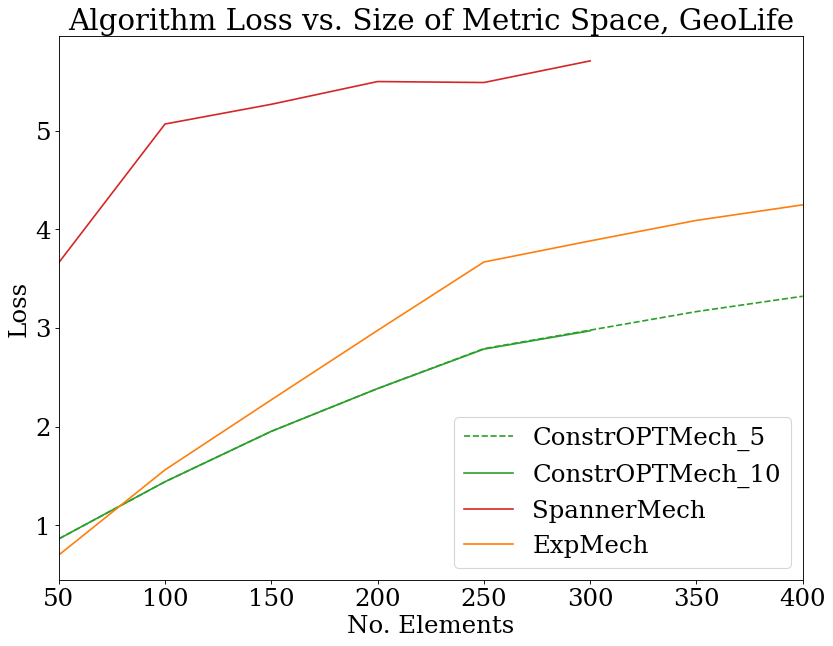

In [48]:
fig, ax = plt.subplots()
ax.plot(*constr_loss3, label=constr_label+'_5', color='tab:green', linestyle='dashed')
ax.plot(*constr_loss2, label=constr_label+'_10', color='tab:green')
ax.plot(*spanner_loss2, label=spanner_label, color='tab:red')
ax.plot(*exp_loss2, label=exp_label, color='tab:orange')
ax.set_xlim(50, 400)
ax.set_xlabel('No. Elements')
ax.set_ylabel('Loss')
ax.set_title('Algorithm Loss vs. Size of Metric Space, GeoLife')
ax.legend()

In [22]:
pts = [50, 150, 300, 400]
ans = ''
for p in pts:
    ans += '%d & ' % p
print(ans[:-2] + '\\\\ \\hline')
ans = ''
for p in pts[:-1]:
    mem = constr_data[p]['lp_shape'][0][0]
    time = np.quantile(constr_data[p]['time'][0], 0.5)
    ans += '%0.2f sec, \\num{%0.2e} nz & ' % (time, mem)
print(ans[:-2] + '\\\\ \\hline')
ans = ''
for p in pts:
    mem = constr_data_5[p]['lp_shape'][0][0]
    time = np.quantile(constr_data_5[p]['time'][0], 0.5)
    ans += '%0.2f sec, \\num{%0.2e} nz & ' % (time, mem)
print(ans[:-2] + '\\\\ \\hline')
ans = ''
for p in pts[:-1]:
    mem = spanner_data[p]['lp_shape'][0][0]
    if 'time' in spanner_data[p]:
        time = np.quantile(spanner_data[p]['time'][0], 0.5)
        ans += '%0.2f sec, \\num{%0.2e} nz & ' % (time, mem)
    else:
        ans += '-- sec, \\num{%0.2e} nz & ' % (mem)
print(ans[:-2] + '\\\\ \\hline')

50 & 150 & 300 & 400 \\ \hline
1.68 sec, \num{3.33e+04} nz & 31.28 sec, \num{2.71e+05} nz & 611.05 sec, \num{1.10e+06} nz \\ \hline
0.80 sec, \num{1.48e+04} nz & 15.76 sec, \num{1.56e+05} nz & 127.07 sec, \num{4.59e+05} nz & 447.10 sec, \num{7.76e+05} nz \\ \hline
0.85 sec, \num{1.62e+04} nz & 74.77 sec, \num{1.52e+05} nz & 495.96 sec, \num{6.59e+05} nz \\ \hline


In [31]:
constr_data[300]['lp_shape']

[(1096672, (458786, 3301)),
 (1096672, (458786, 3301)),
 (1096672, (458786, 3301)),
 (1096672, (458786, 3301))]

In [32]:
spanner_data[300]['lp_shape']

[(658800, (329700, 90001)),
 (658800, (329700, 90001)),
 (658800, (329700, 90001)),
 (658800, (329700, 90001)),
 (658800, (329700, 90001)),
 (658800, (329700, 90001))]

In [33]:
constr_data_5[300]['lp_shape']

[(459148, (140024, 1801)), (459148, (140024, 1801))]